In [5]:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx



from SALib.analyze import sobol


In [16]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

2.0.1
3.1


In [8]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time



In [10]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
# our objective= minimize total costs

''''
2: expected damages, dike investment costs, rfr costs, evacuation cost, and casualties (choose this)
4: Expected damages, dike investment cost and casualties disaggregated over dike rings and room for the river and evacuation costs (choose this)
'''
dike_model, planning_steps = get_model_for_problem_formulation(2)


In [11]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

# location dependent parameters
# Bmax = final breach width (absolute)
# pfail = dike failure probability
# Brate = Breach width model (relative) /day
# ID_flood wafe shape

#discount rate Multiple Decision Points: The dike_model likely involves multiple decision points or stages over time. Each discount rate parameter can correspond to a specific decision point or phase in the model. For example, discount rate 0 may be associated with immediate costs and benefits, discount rate 1 with short-term impacts, and discount rate 2 with long-term consequences. This allows for evaluating the sensitivity of decisions and outcomes to varying discount rates at different stages.


CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [13]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary


# Each lever has a specific name and range of values denoted by the indexes. Let's break down the levers and their indexes: The indexes indicate the available options or levels for each lever. For example, the '0_RfR 0' lever has two options: 0 and 1. Similarly, the 'A.1_DikeIncrease 0' lever has eleven options from 0 to 10. The specific index value chosen for each lever determines the level or intensity of the intervention applied during the model simulation.
#Rfr: different project:switch on 1 off 0
#Dike_increase: different intensity in dike increase 0 to 10

for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [14]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x000001D416ADE480>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs', 'A.5_Dike Investment Costs'), function=<function sum_over at 0x000001D416ADE480>)
ScalarOutcome('RfR Investment Costs', variable_name=('RfR Total Costs',), function=<function sum_over at 0x000001D416ADE480>)
ScalarOutcome('Evacuation Costs', variable_name=('Expected Evacuation Costs',), function=<function sum_over at 0x000001D416ADE480>)
ScalarOutcome('Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 'A.3_Expected Number of Deaths', 'A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths'), function

In [15]:
# running the model through EMA workbench
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=50, policies=4)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 50 scenarios * 4 policies * 1 model(s) = 200 experiments
100%|████████████████████████████████████████| 200/200 [00:34<00:00,  5.79it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [17]:
# observing the simulation runs
experiments, outcomes = results
print(outcomes.keys())


# Location dependent
# total costs
# expected number ot deaths
# RfR Total Costs
# Expected Evacuation costs



dict_keys(['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths'])


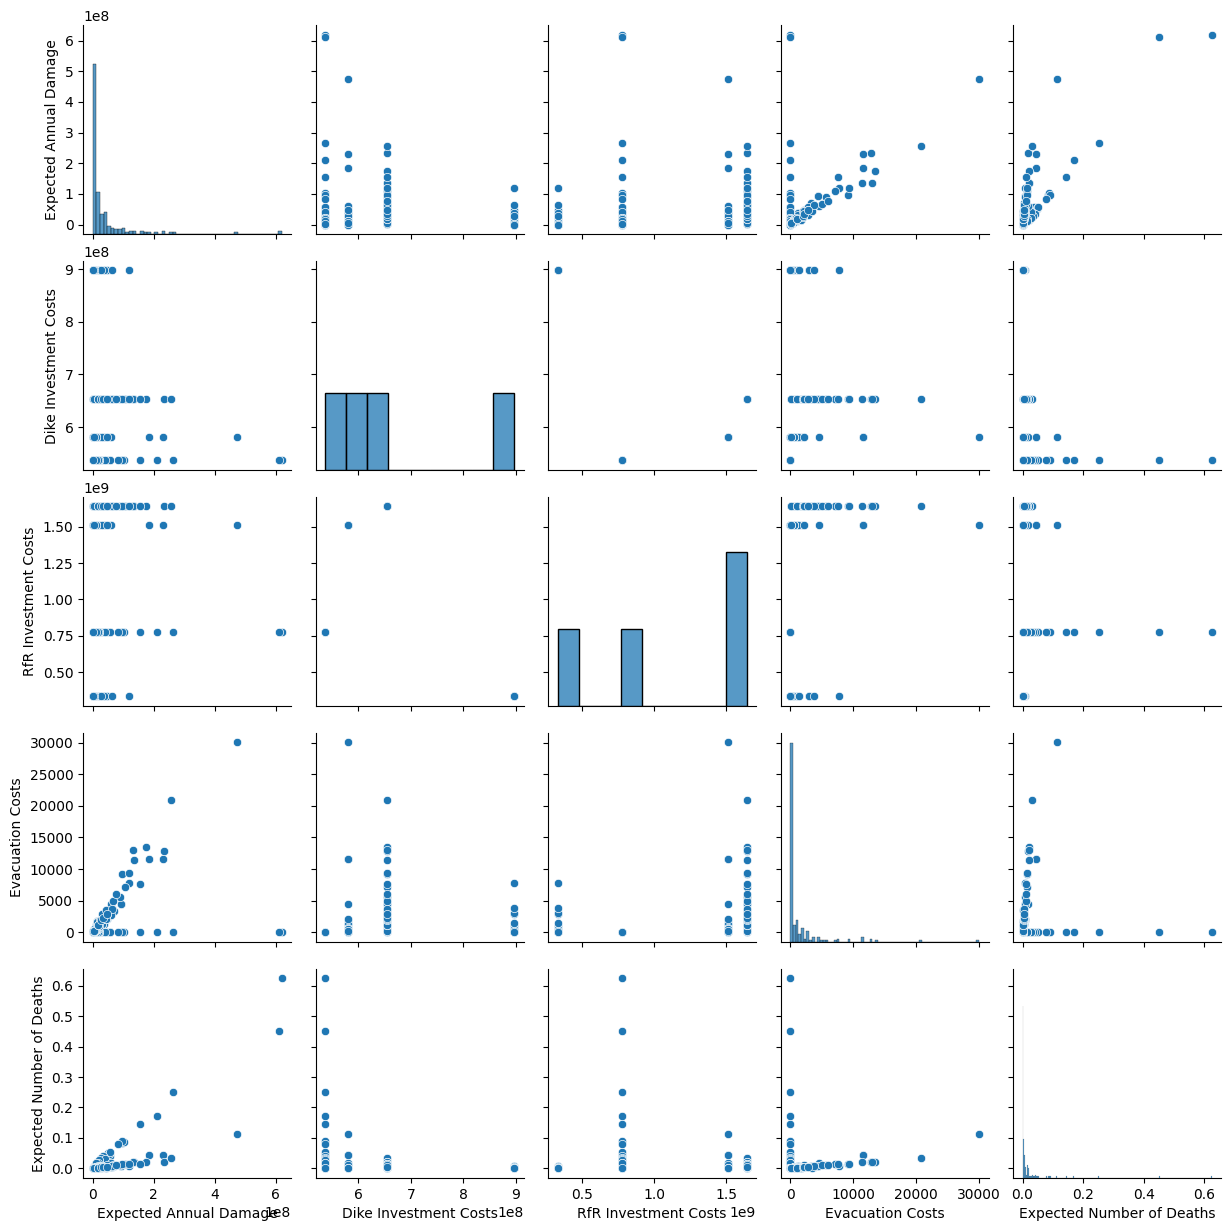

<Figure size 640x480 with 0 Axes>

In [18]:
# only works because we have scalar outcomes
sns.pairplot(pd.DataFrame.from_dict(outcomes))
plt.show()
plt.savefig('outcomes vs. uncertainty parameter.png')

In [25]:
# defining specific policies
# for example, policy 1 is about extra protection in upper boundary
# policy 2 is about extra protection in lower boundary
# policy 3 is extra protection in random locations

# BAU = Rfr (x,t) ; Dike increase (x,t) =0
# Dike heightening scenario RFR=0 Dike heigth = 5
#


def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies = [
    Policy(
        "BAU",
        **dict(
            get_do_nothing_dict(),
        )
    ),
    Policy(
        "Dike Increase medium",
        **dict(get_do_nothing_dict(),
                **{'A.1_DikeIncrease 0':5,
                  'A.1_DikeIncrease 1':5,
                  'A.1_DikeIncrease 2':5,
                  'A.2_DikeIncrease 0':5,
                  'A.2_DikeIncrease 1':5,
                  'A.2_DikeIncrease 2':5,
                  'A.3_DikeIncrease 0':5,
                  'A.3_DikeIncrease 1':5,
                  'A.3_DikeIncrease 2':5,
                  'A.4_DikeIncrease 0':5,
                  'A.4_DikeIncrease 1':5,
                  'A.4_DikeIncrease 2':5,
                  'A.5_DikeIncrease 0':5,
                  'A.5_DikeIncrease 1':5,
                  'A.5_DikeIncrease 2':5})
        ),
    Policy(
        "Dike Increase high",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':5,
                  'A.1_DikeIncrease 1':10,
                  'A.1_DikeIncrease 2':10,
                  'A.2_DikeIncrease 0':10,
                  'A.2_DikeIncrease 1':10,
                  'A.2_DikeIncrease 2':5,
                  'A.3_DikeIncrease 0':5,
                  'A.3_DikeIncrease 1':5,
                  'A.3_DikeIncrease 2':5,
                  'A.4_DikeIncrease 0':5,
                  'A.4_DikeIncrease 1':5,
                  'A.4_DikeIncrease 2':5,
                  'A.5_DikeIncrease 0':5,
                  'A.5_DikeIncrease 1':5,
                  'A.5_DikeIncrease 2':5}
        )
    ),
]

In [26]:
# pass the policies list to EMA workbench experiment runs
n_scenarios = 100
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 100 scenarios * 3 policies * 1 model(s) = 300 experiments
100%|████████████████████████████████████████| 300/300 [00:57<00:00,  5.22it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [27]:
experiments, outcomes = results

In [40]:
# only works because we have scalar outcomes
pd.DataFrame(outcomes)

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,5.397251e+07,0.000000,2.855951e+08,0.305712,0.000000e+00,0.000000,4.079644e+05,0.000222,0.000000e+00,0.000000,253800000.0,0.0
1,5.397251e+07,0.000000,4.226675e+07,0.048395,5.694222e+08,1.183160,0.000000e+00,0.000000,2.661067e+08,0.272617,253800000.0,0.0
2,5.397251e+07,0.000000,1.234340e+08,0.121199,7.340429e+06,0.014070,9.977163e+07,0.045943,3.171942e+08,0.291478,253800000.0,0.0
3,5.397251e+07,0.000000,9.138135e+07,0.076573,2.383002e+09,3.532241,0.000000e+00,0.000000,0.000000e+00,0.000000,253800000.0,0.0
4,5.397251e+07,0.000000,7.655385e+07,0.074705,3.294232e+08,0.601329,0.000000e+00,0.000000,1.939340e+08,0.177333,253800000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.000000e+00,0.000000,2.335876e+08,0.284936,2.879840e+07,0.000000,0.000000e+00,0.000000,1.073376e+08,0.123183,369700000.0,0.0
296,0.000000e+00,0.000000,2.370852e+08,0.204504,2.879840e+07,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,369700000.0,0.0
297,2.547996e+09,1.622123,7.617759e+08,0.617429,2.879840e+07,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,369700000.0,0.0
298,2.601770e+09,1.622963,2.001664e+08,0.160525,2.879840e+07,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,369700000.0,0.0


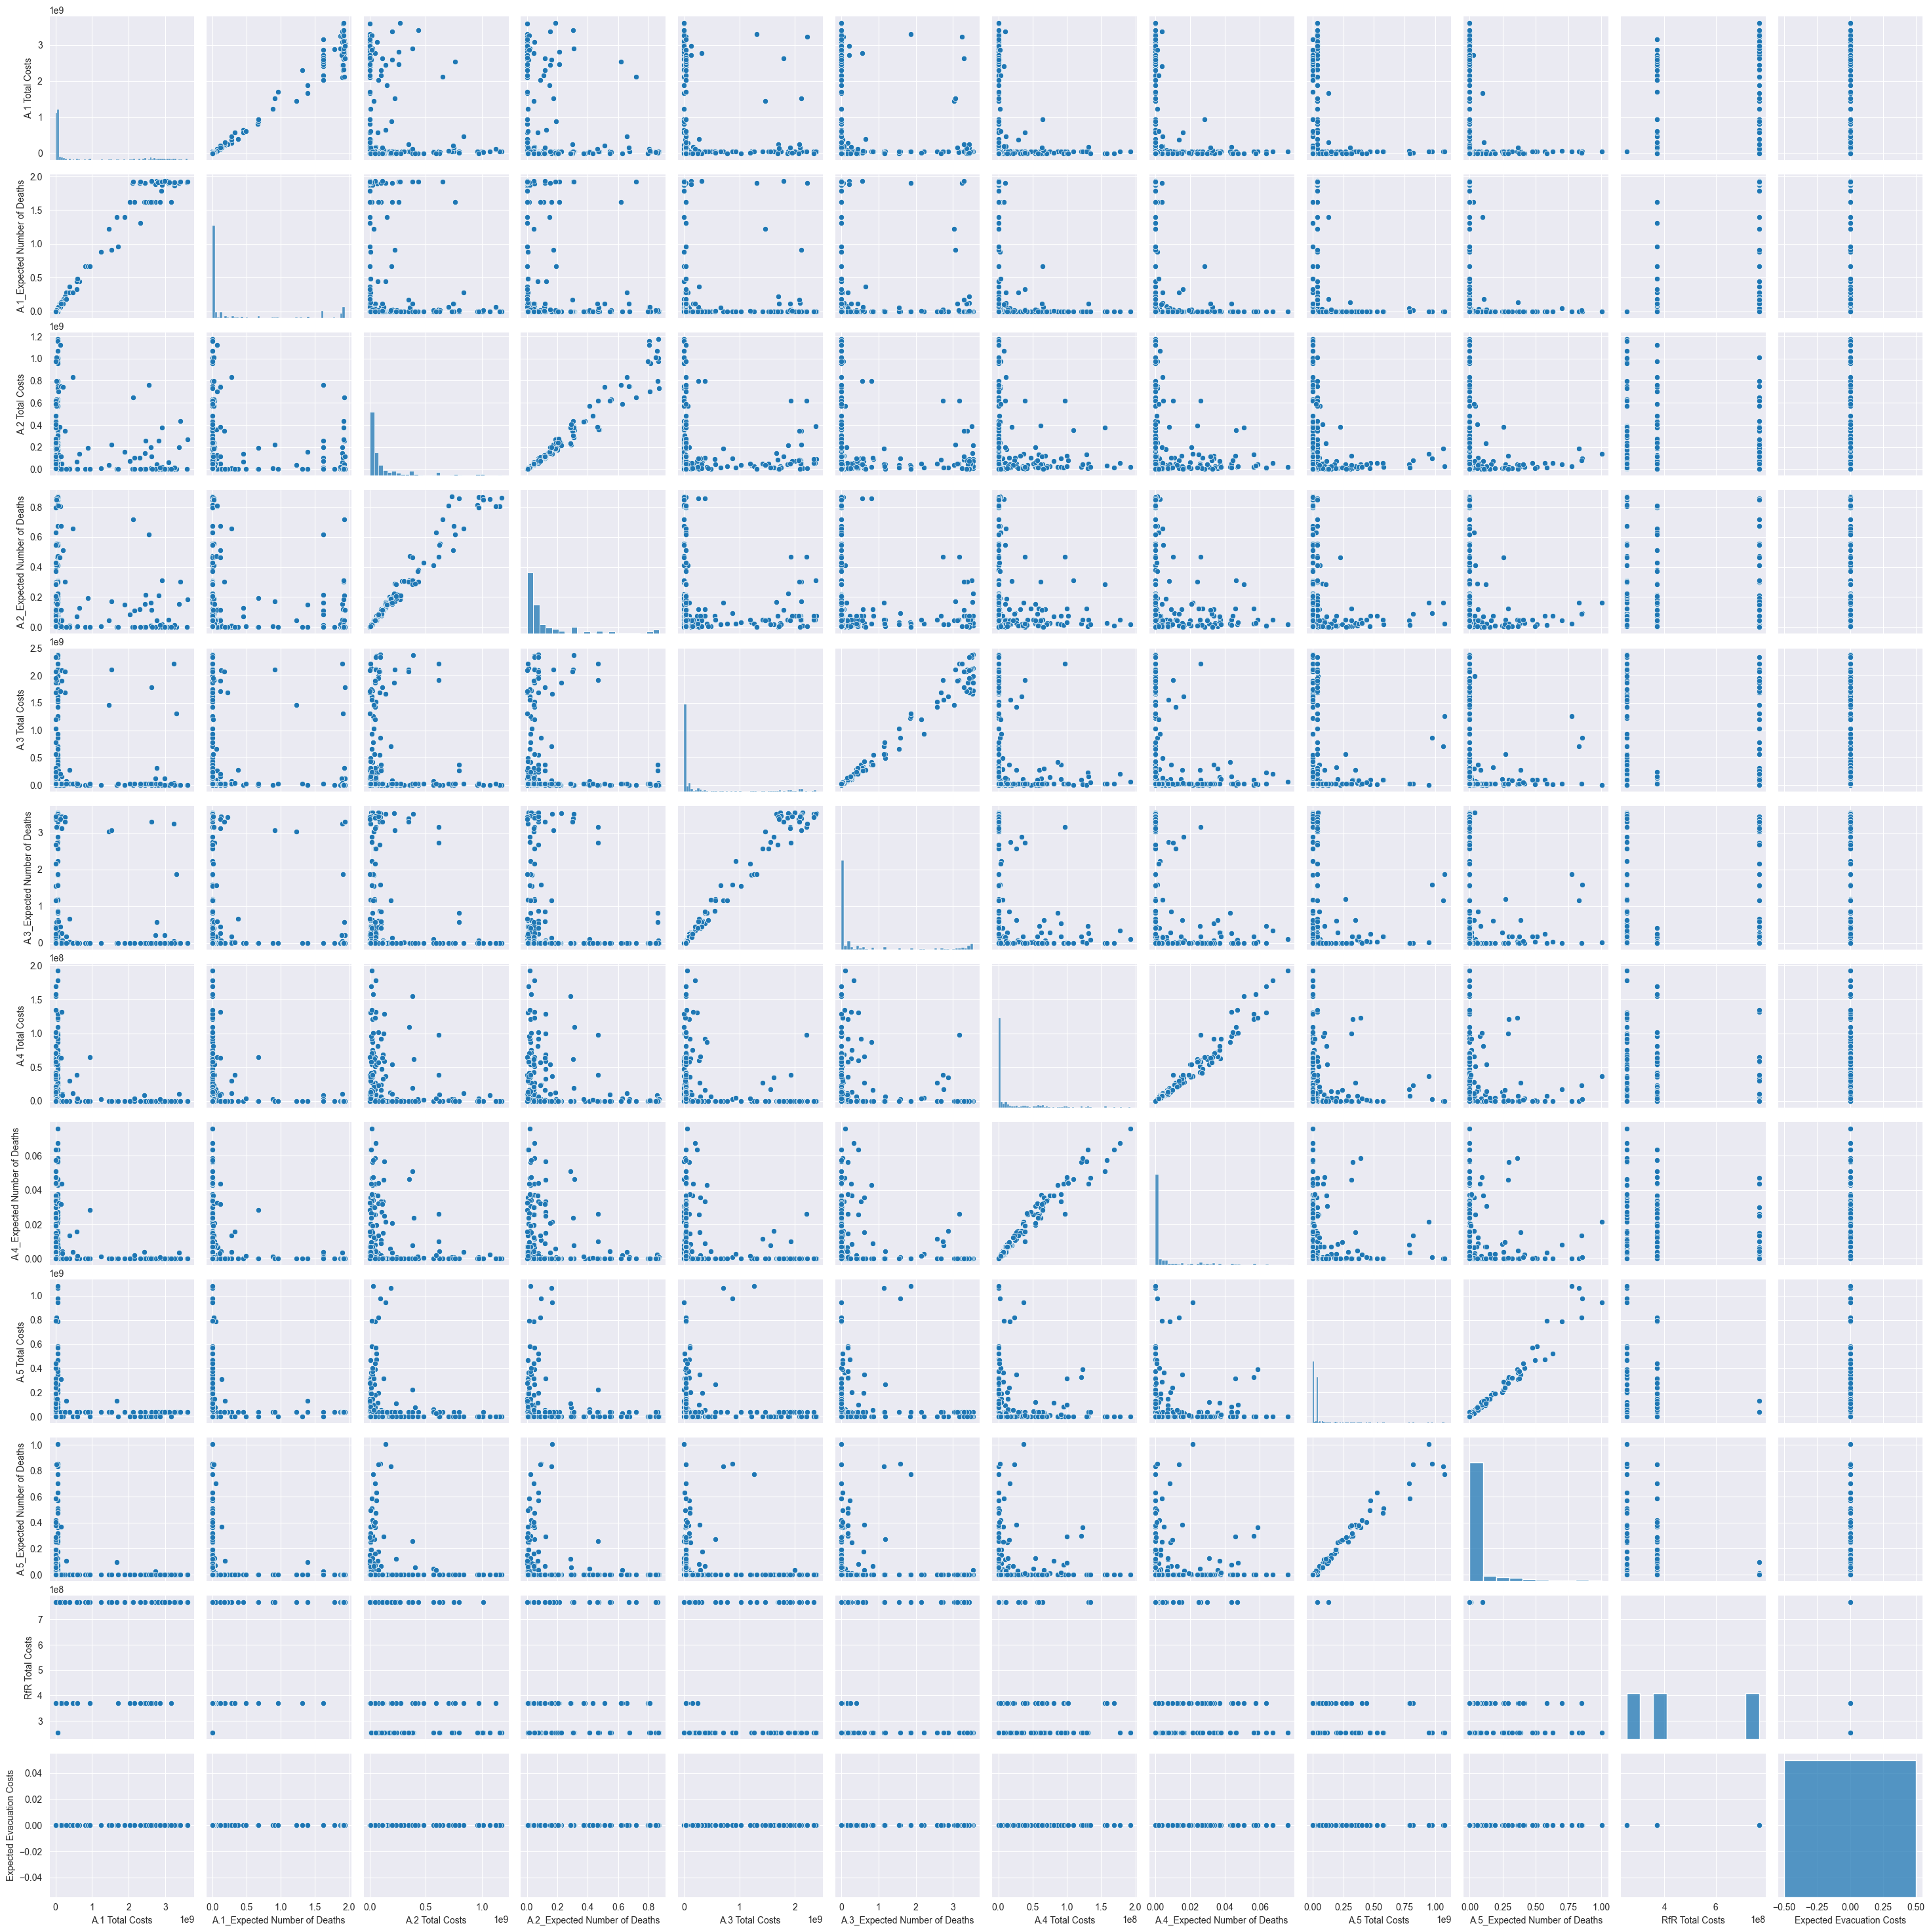

In [30]:
sns.pairplot(pd.DataFrame.from_dict(outcomes))
plt.show()




In [32]:
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

problem = get_SALib_problem(uncertainties)
print(problem)


{'num_vars': 19, 'names': ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 133), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (0, 4), (0, 4), (0, 4)]}


In [38]:
n_exp = 100
from ema_workbench import Policy, perform_experiments
from ema_workbench import Samplers

experiments_sobol, outcomes_sobol = perform_experiments(dike_model, scenarios=n_exp,                                    uncertainty_sampling=Samplers.SOBOL)





C:\Users\admin\Documents\GitHub\epa1361_open\venv\Lib\site-packages\scipy\stats\_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 4000 scenarios * 1 policies * 1 model(s) = 4000 experiments


  0%|                                                 | 0/4000 [00:00<?, ?it/s][MainProcess/INFO] performing experiments sequentially
[MainProcess/ERROR] 'DikeIncrease 0'
Traceback (most recent call last):
  File "C:\Users\admin\Documents\GitHub\epa1361_open\venv\Lib\site-packages\ema_workbench\em_framework\experiment_runner.py", line 91, in run_experiment
    model.run_model(scenario, policy)
  File "C:\Users\admin\Documents\GitHub\epa1361_open\venv\Lib\site-packages\ema_workbench\util\ema_logging.py", line 152, in wrapper
    res = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\admin\Documents\GitHub\epa1361_open\venv\Lib\site-packages\ema_workbench\em_f

EMAError: exception in run_model
Caused by: KeyError: 'DikeIncrease 0'